# A Deep Neural Network

I am using a ConvNet in tandem with a Gaussian Process to regress 32 electrode readings into the expected lung volume measurement. Inputs are 32x224 matrices, corresponding to 32 electrodes, with 224 patterns. 

I also include occlusions and elevations as targets. 

In [1]:
%matplotlib inline

#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
np.random.seed(32)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
# Make Cyclic By Rolling Over 1st K rows to Edge
cyclic = lambda x, K=4: np.append(x,x[:,:,:K,:,:],axis=2)
hsize  = 7   #7 , 11
nelct  = 16  #16, 32
npats  = 112 #112,224

In [5]:
# Load Others
def load_data(path,test=False):
    if not test:
        dfile = path + '/train.csv'
        data   = pd.read_csv(dfile,header=None).values
        x_data = data[:,:-1].reshape((hsize,-1,nelct,npats,1)).transpose(1,0,2,3,4)
        x_data = cyclic(x_data)
        y_data = data[:, -1].reshape((hsize,-1)).transpose(1,0)
    
    else:
        tfile = path + '/test.csv'
        data   = pd.read_csv(tfile,header=None).values
        x_data = data[:,:-1].reshape((hsize,-1,nelct,npats,1)).transpose(1,0,2,3,4)
        x_data = cyclic(x_data)
        y_data = data[:, -1].reshape((hsize,-1)).transpose(1,0)
        
    return x_data,y_data

In [6]:
# Load Data
path  = 'unknown_tank'
x_data,l_data=load_data(path)   # x: -1,11,32,224,1

In [7]:
print 'X shape:', x_data.shape
print 'L shape:', l_data.shape

X shape: (12000, 7, 20, 112, 1)
L shape: (12000, 7)


In [8]:
# Scale Data
ysclr  = RobustScaler().fit(l_data.reshape(-1,1))
y_data = ysclr.transform(l_data.reshape(-1,1)).reshape(-1,hsize)

In [9]:
# Reshaping Back
x_train,x_valid,y_train,y_valid = train_test_split(x_data,y_data,test_size=0.3,random_state=32)

nshp = (-1,) + x_data.shape[2:]
x_train = x_train.reshape(nshp)
y_train = y_train.reshape(-1)

x_valid = x_valid.reshape(nshp)
y_valid = y_valid.reshape(-1)

print 'X train:', x_train.shape
print 'Y train:', y_train.shape

X train: (58800, 20, 112, 1)
Y train: (58800,)


## Regressor Model

In [10]:
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, AveragePooling2D, UpSampling2D
from keras.layers import Flatten, Reshape,Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import PReLU
from keras import regularizers
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

import tensorflow as tf

Using TensorFlow backend.


In [18]:
## Training Params
num_batch = 32#256
num_epoch = 120#50#80#100
patience  = 10

# Parameters
# npat,ndim,_ = x_train.shape[1:]
npat,ndim = 20,112 #36,224
# npat,ndim = 36,224

In [19]:
# Build DNN
def build_model():
    x = Input(shape=(npat,ndim,1),name='Input')
    h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
    h = BatchNormalization()(h)
    h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
    h = BatchNormalization()(h)
    h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
    h = BatchNormalization()(h)
    h = AveragePooling2D((2,2),strides=(2,2))(h)
    h = Flatten()(h)
    h = Dense(7,activation='tanh',name='L4')(h)
    y = Dense(1,activation='linear',name='Output')(h)
    model   = Model(x,y)
    encoder = Model(x,h) 
    return model, encoder

In [20]:
# Compile Model
model,encoder = build_model()
encoder.compile(optimizer='adam', loss='mean_squared_error')

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 20, 112, 1)        0         
_________________________________________________________________
L1 (Conv2D)                  (None, 10, 38, 28)        448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 38, 28)        112       
_________________________________________________________________
L2 (Conv2D)                  (None, 5, 13, 16)         4048      
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 13, 16)         64        
_________________________________________________________________
L3 (Conv2D)                  (None, 5, 5, 15)          2175      
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 15)          60        
__________

In [21]:
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

In [22]:
flops = get_flops(model)
print 'Total FLOPs: {:,}'.format(flops)

Total FLOPs: 32,992


In [23]:
# checkpoint
filepath=path+"/bestnet.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [24]:
# Train
log = model.fit(x_train, y_train,
                batch_size=num_batch,
                epochs=num_epoch,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(x_valid,y_valid))

Train on 58800 samples, validate on 25200 samples
Epoch 1/120
58800/58800 [==============================] - 16s 272us/step - loss: 0.0179 - val_loss: 0.0048

Epoch 00001: val_loss improved from inf to 0.00485, saving model to unknown_tank/bestnet.h5
Epoch 2/120
58800/58800 [==============================] - 8s 137us/step - loss: 0.0060 - val_loss: 0.0015

Epoch 00002: val_loss improved from 0.00485 to 0.00153, saving model to unknown_tank/bestnet.h5
Epoch 3/120
58800/58800 [==============================] - 9s 145us/step - loss: 0.0037 - val_loss: 8.7265e-04

Epoch 00003: val_loss improved from 0.00153 to 0.00087, saving model to unknown_tank/bestnet.h5
Epoch 4/120
58800/58800 [==============================] - 8s 141us/step - loss: 0.0024 - val_loss: 0.0011

Epoch 00004: val_loss did not improve
Epoch 5/120
58800/58800 [==============================] - 8s 143us/step - loss: 0.0015 - val_loss: 0.0011

Epoch 00005: val_loss did not improve
Epoch 6/120
58800/58800 [====================


Epoch 00048: val_loss did not improve
Epoch 49/120
58800/58800 [==============================] - 8s 133us/step - loss: 8.6353e-05 - val_loss: 1.3487e-04

Epoch 00049: val_loss did not improve
Epoch 50/120
58800/58800 [==============================] - 8s 135us/step - loss: 6.5171e-05 - val_loss: 3.1045e-05

Epoch 00050: val_loss did not improve
Epoch 51/120
58800/58800 [==============================] - 8s 135us/step - loss: 6.8703e-05 - val_loss: 2.7244e-05

Epoch 00051: val_loss did not improve
Epoch 52/120
58800/58800 [==============================] - 8s 134us/step - loss: 7.1308e-05 - val_loss: 1.0877e-04

Epoch 00052: val_loss did not improve
Epoch 53/120
58800/58800 [==============================] - 8s 133us/step - loss: 7.0903e-05 - val_loss: 3.1939e-05

Epoch 00053: val_loss did not improve
Epoch 54/120
58800/58800 [==============================] - 8s 133us/step - loss: 6.2835e-05 - val_loss: 1.9047e-05

Epoch 00054: val_loss did not improve
Epoch 55/120
58800/58800 [=====

58800/58800 [==============================] - 8s 135us/step - loss: 4.3967e-05 - val_loss: 5.4790e-05

Epoch 00100: val_loss did not improve
Epoch 101/120
58800/58800 [==============================] - 8s 135us/step - loss: 3.9961e-05 - val_loss: 2.6208e-04

Epoch 00101: val_loss did not improve
Epoch 102/120
58800/58800 [==============================] - 8s 134us/step - loss: 4.3449e-05 - val_loss: 6.2112e-05

Epoch 00102: val_loss did not improve
Epoch 103/120
58800/58800 [==============================] - 8s 135us/step - loss: 3.7160e-05 - val_loss: 2.2943e-05

Epoch 00103: val_loss did not improve
Epoch 104/120
58800/58800 [==============================] - 8s 136us/step - loss: 3.6050e-05 - val_loss: 1.5743e-05

Epoch 00104: val_loss did not improve
Epoch 105/120
58800/58800 [==============================] - 8s 135us/step - loss: 3.2678e-05 - val_loss: 1.2831e-05

Epoch 00105: val_loss improved from 0.00001 to 0.00001, saving model to unknown_tank/bestnet.h5
Epoch 106/120
58800/

In [31]:
model = load_model(filepath)

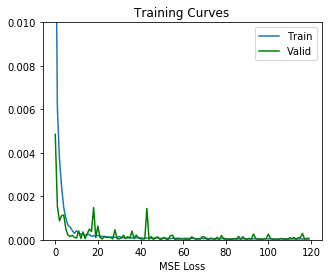

In [25]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.ylim([0,0.01])
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid']);
plt.savefig(path+'/loss_curves.pdf',dpi=200)

In [26]:
tloss = log.history['loss']
vloss = log.history['val_loss']
epchs = np.arange(len(tloss))

dl = pd.DataFrame({
    'Epoch': epchs,
    'Tloss': tloss,
    'Vloss': vloss
})

dl.to_csv(path+'/loss_curves.csv',index=False)

### Validation Curves

In [32]:
y_vpred = model.predict(x_valid).reshape(-1,hsize)
y_vtrue = y_valid.reshape(-1,hsize)

In [33]:
rmse = lambda x,y : np.sqrt(np.mean((x-y)**2))

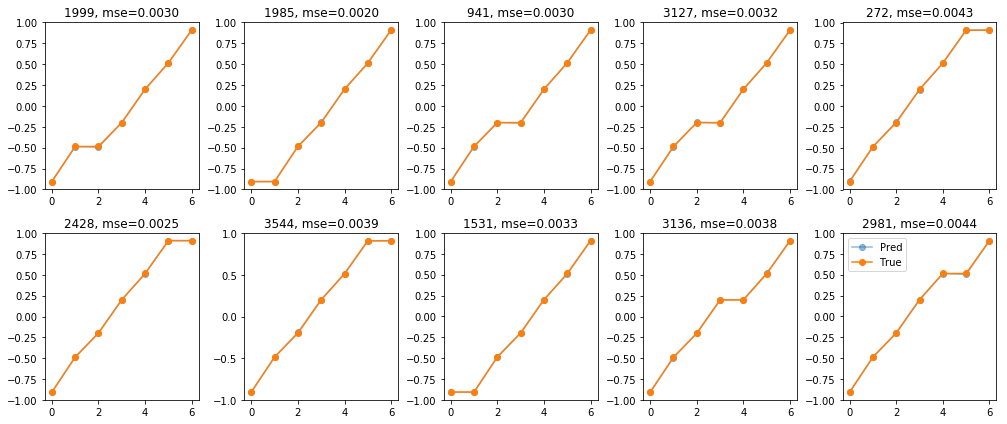

In [34]:
K = 10
row = 2
col = K/row

sidx = random.sample(range(len(y_vtrue)),K)

plt.figure(figsize=(14,6));
for i,k in enumerate(sidx):
    plt.subplot(row,col,i+1)
    plt.plot(y_vpred[k],'o-',label='Pred',alpha=0.5);
    plt.plot(y_vtrue[k],'o-',label='True');
    mse = rmse(y_vpred[k],y_vtrue[k])
    header = '{0}, mse={1:.04f}'.format(k,mse)
    plt.title(header);
    
plt.legend();
plt.tight_layout();
plt.savefig(path+'/valid_plots.pdf',dpi=200)

In [30]:
# # Save
# y_tst = ysclr.inverse_transform(y_vtrue.reshape(-1,1)).squeeze()
# y_prd = ysclr.inverse_transform(y_vpred.reshape(-1,1)).squeeze()

# vdata = np.stack([y_tst,y_prd],axis=1)
# oname = path +'/valid_results.csv'
# np.savetxt(oname,vdata,delimiter=',',header='True,Pred')

## Test Curves

In [35]:
# Generate Predictions for Test Set
x_test,y_test = load_data(path,test=True)
x_test = x_test.reshape(nshp)

In [36]:
y_pred = model.predict(x_test)
y_pred = ysclr.inverse_transform(y_pred).reshape(-1,hsize)

In [37]:
y_test.shape

(15, 7)

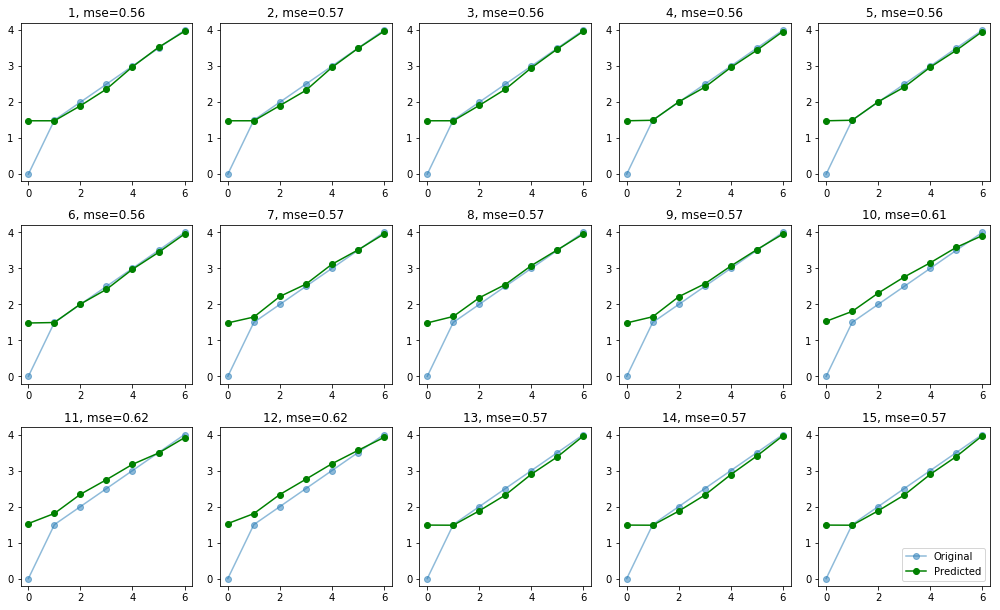

In [38]:
# Plot Test Examples
row = 10#3
col = 5

plt.figure(figsize=(14,28));
for i, (yt,yp) in enumerate(zip(y_test,y_pred)):
    plt.subplot(row,col,i+1)
    plt.plot(yt,'o-',label='True',alpha=0.5);
    plt.plot(yp,'go-',label='Pred');
    mse = rmse(yp,yt)
    header = '{0}, mse={1:.02f}'.format(i+1,mse)
    plt.title(header);

plt.legend(['Original','Predicted'],loc=4)
plt.tight_layout()
plt.savefig(path+'/test_plots.pdf',dpi=200)

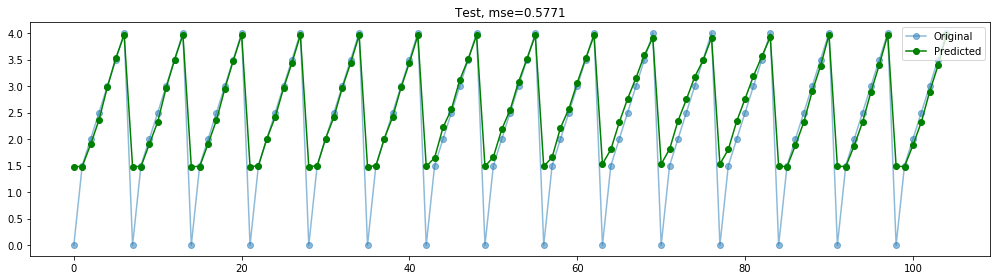

In [39]:
# Plot Results
plt.figure(figsize=(14,4))
plt.subplot(111)
plt.plot(y_test[:25,:].flatten(),'o-',alpha=0.5)
plt.plot(y_pred[:25,:].flatten(),'go-')
mse = rmse(y_pred,y_test)
header = 'Test, mse={0:.04f}'.format(mse)
plt.title(header)

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()
plt.savefig(path+'/joined_test_plots.pdf',dpi=200)

In [28]:
# Save Values
oname = path + '/ypred.csv'
tname = path + '/ytest.csv'
np.savetxt(oname,y_pred,delimiter=',')
np.savetxt(tname,y_test,delimiter=',')

----